### Generate an array of the lat, lons from the SWOT passes that we use to extract simulation data

In [4]:
import os
import re
from glob import glob
from netCDF4 import Dataset
import numpy as np

def extract_unique_pass_lat_lon(folder, basic=True):

    if basic:
        pattern = os.path.join(folder, 'SWOT_L2_LR_SSH_Basic_*.nc')
        regex = r'Basic_\d+_(\d+)'  # extracts pass number
    else:
        pattern = os.path.join(folder, 'SWOT_L2_LR_SSH_Expert_*.nc')
        regex = r'Expert_\d+_(\d+)'

    files = sorted(glob(pattern))
    seen_passes = set()
    results = []

    for file in files:
        fname = os.path.basename(file)
        match = re.search(regex, fname)
        if not match:
            continue
        pass_num = int(match.group(1))

        if pass_num in seen_passes:
            continue  # skip duplicates, only keep first seen

        try:
            with Dataset(file, 'r') as nc:
                lat = np.array(nc.variables['latitude'][:], copy=True)
                lon = np.array(nc.variables['longitude'][:], copy=True)

                nx, ny = lon.shape

                mask = np.isfinite(lat) & np.isfinite(lon)
                lat = np.where(mask, lat, np.nan)
                lon = np.where(mask, lon, np.nan)

                if lat.size == 0 or lon.size == 0:
                    continue  # skip if all values are invalid
                
            results.append((pass_num, lat, lon))
            seen_passes.add(pass_num)
        except Exception as e:
            print(f"Failed to load {fname}: {e}")
            continue

    results.sort(key=lambda x: x[0])  # sort by pass_num
    return results

swot_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/CALVAL/'
pass_coords = extract_unique_pass_lat_lon(swot_folder, basic=True)

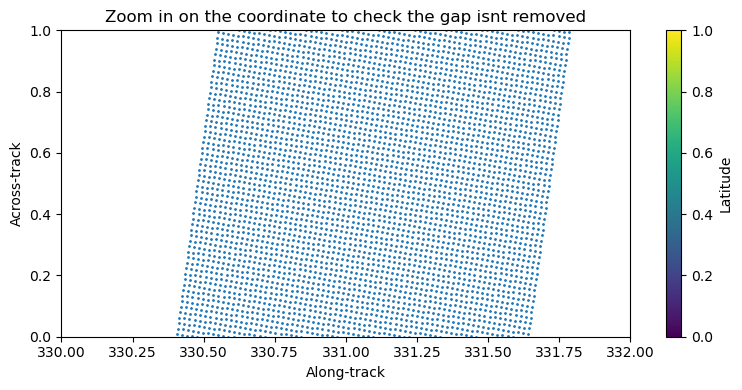

In [5]:
import matplotlib.pyplot as plt
# Assume pass_coords is already loaded and pass_coords[4][1] is the latitude array
lat = pass_coords[4][1]
lon = pass_coords[4][2]

plt.figure(figsize=(8, 4))
plt.scatter(lon, lat, s = 1)
plt.colorbar(label='Latitude')
plt.xlabel('Along-track')
plt.ylabel('Across-track')
plt.tight_layout()
plt.ylim(0, 1)
plt.xlim(330, 332)
plt.show()

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_unique_swot_passes(pass_coords, title="SWOT Passes", legend_limit=50, pass_nums=None):

    plt.figure(figsize=(15, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True)

    handles = []
    labels = []

    for i, (pass_num, lat, lon) in enumerate(pass_coords):
        if pass_nums is not None and pass_num not in pass_nums:
            continue

        try:
            lat = lat.flatten()
            lon = lon.flatten()

            # Subsample for efficiency
            lat_sub = lat[::100]
            lon_sub = lon[::100]

            (line,) = ax.plot(
                lon_sub,
                lat_sub,
                '.',
                markersize=1.0,
                transform=ccrs.PlateCarree(),
                label=f"Pass {pass_num}" if len(handles) < legend_limit else None,
            )

            if len(handles) < legend_limit:
                handles.append(line)
                labels.append(f"Pass {pass_num}")
        except Exception as e:
            print(f"Skipping pass {pass_num} due to error: {e}")

    if handles:
        ax.legend(handles, labels, loc='lower left', fontsize='small', markerscale=6, ncol=2, frameon=False)

    plt.title(title)
    plt.tight_layout()
    plt.show()


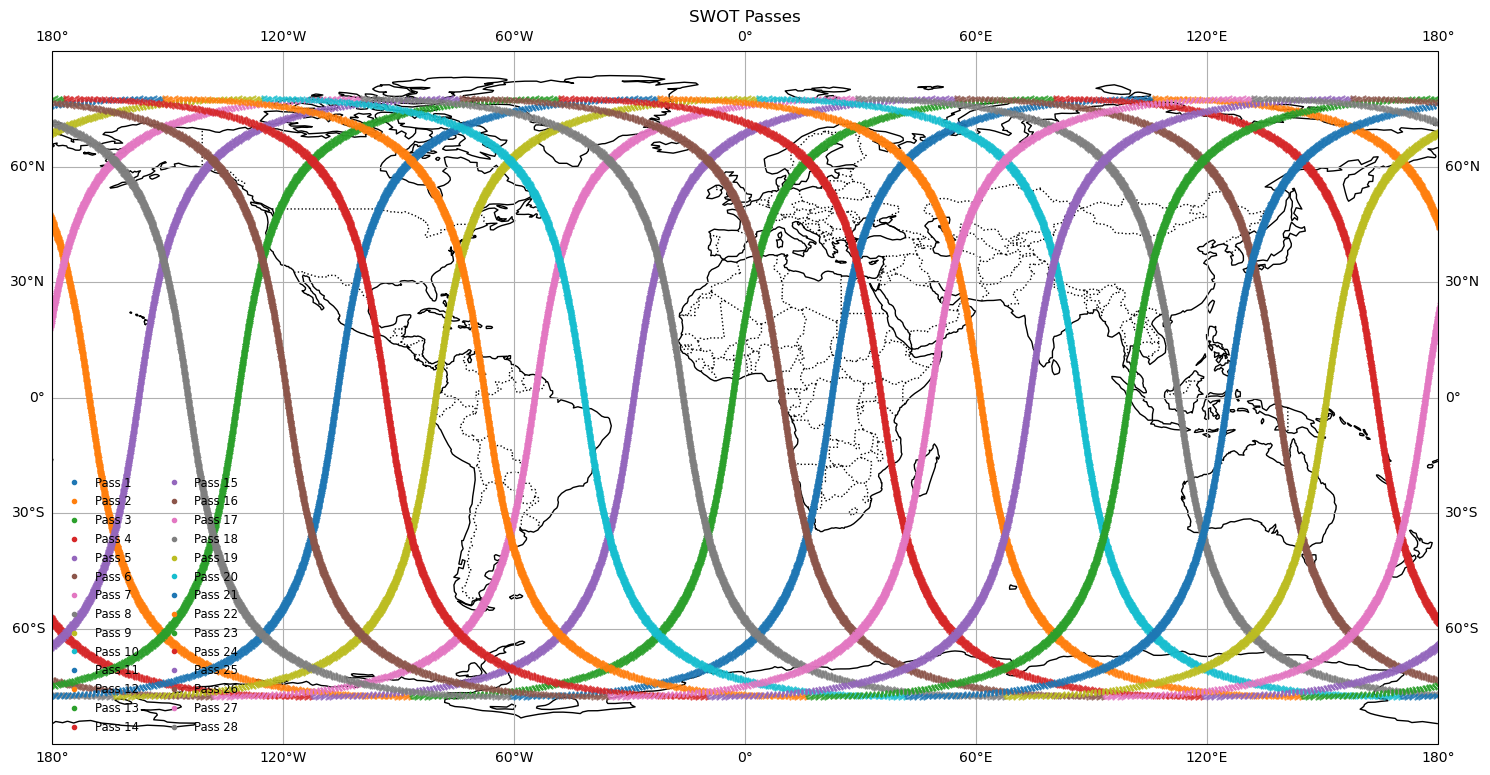

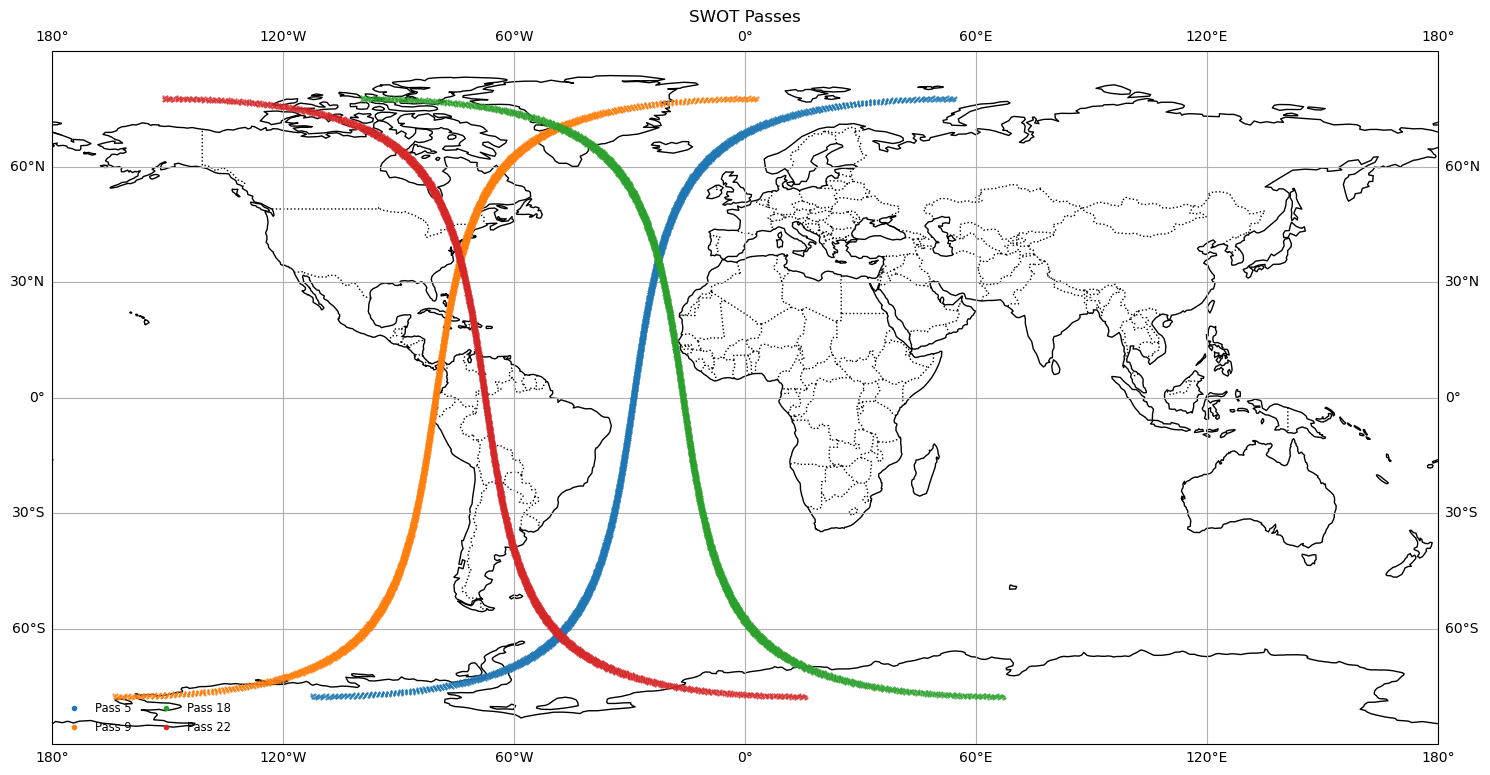

In [28]:
# Plots all passes 
plot_unique_swot_passes(pass_coords)

# Plots specified passes (in the WNA and ENA of the NA simulation)
plot_unique_swot_passes(pass_coords, pass_nums=[9, 22, 18, 5]) 

In [29]:
# Save pass_coords so we can use it to extract the SWOT tracks from simulation data 
import pickle

with open("SWOT_pass_coordinates.pkl", "wb") as f:
    pickle.dump(pass_coords, f)